In [1]:
from skimage.io import imread

img = imread('resources/table.jpg')

In [2]:
import matplotlib.pyplot as plt

plt.imshow(img)

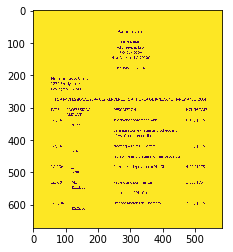

In [3]:
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
gray = rgb2gray(img)
thresh = threshold_otsu(gray)
binary = gray > thresh

plt.imshow(binary)

(672, 585)


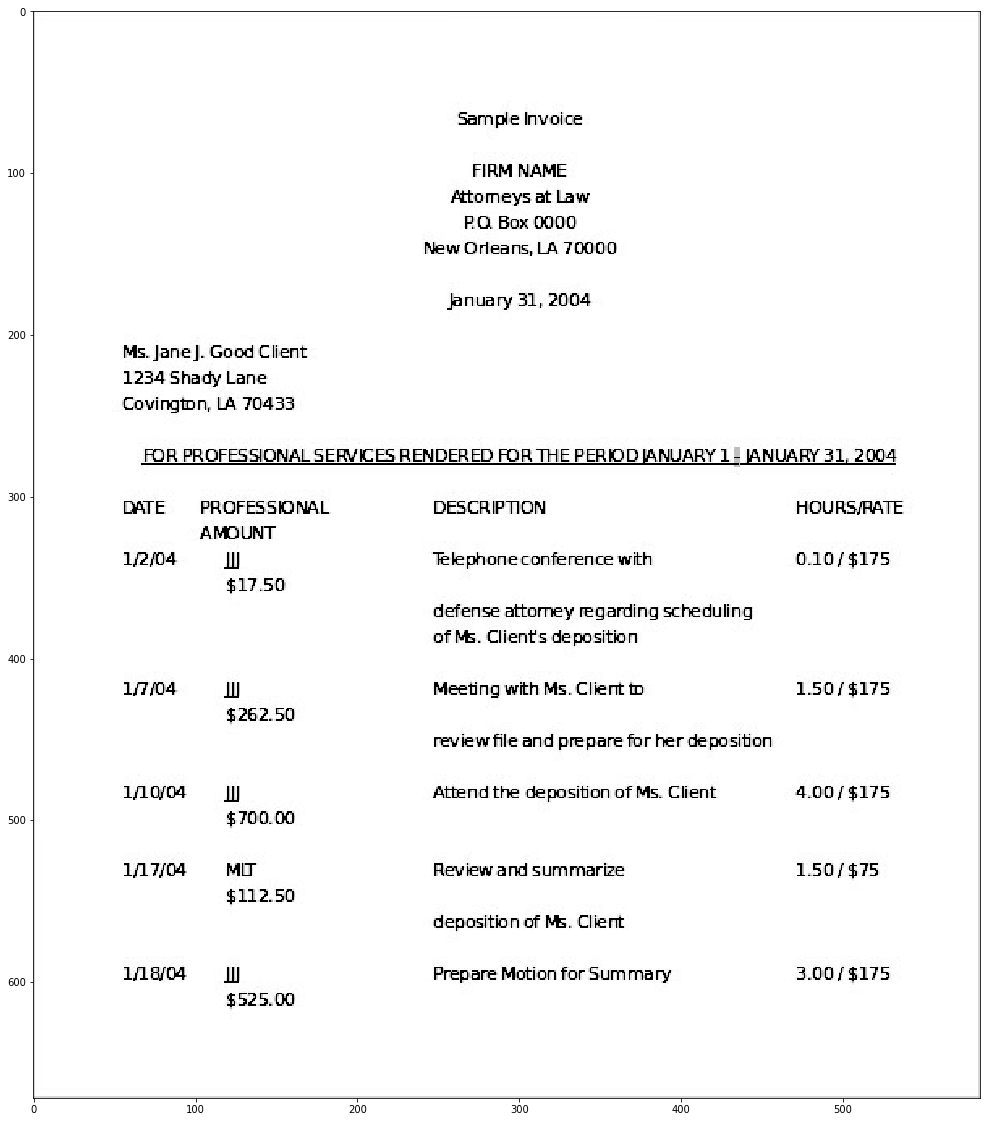

In [4]:
from skimage import img_as_ubyte
print(img_as_ubyte(binary).shape)
plt.figure(figsize=(20,20))
gray_clean = gray * (binary*1)
plt.imshow(gray_clean, cmap="gray")

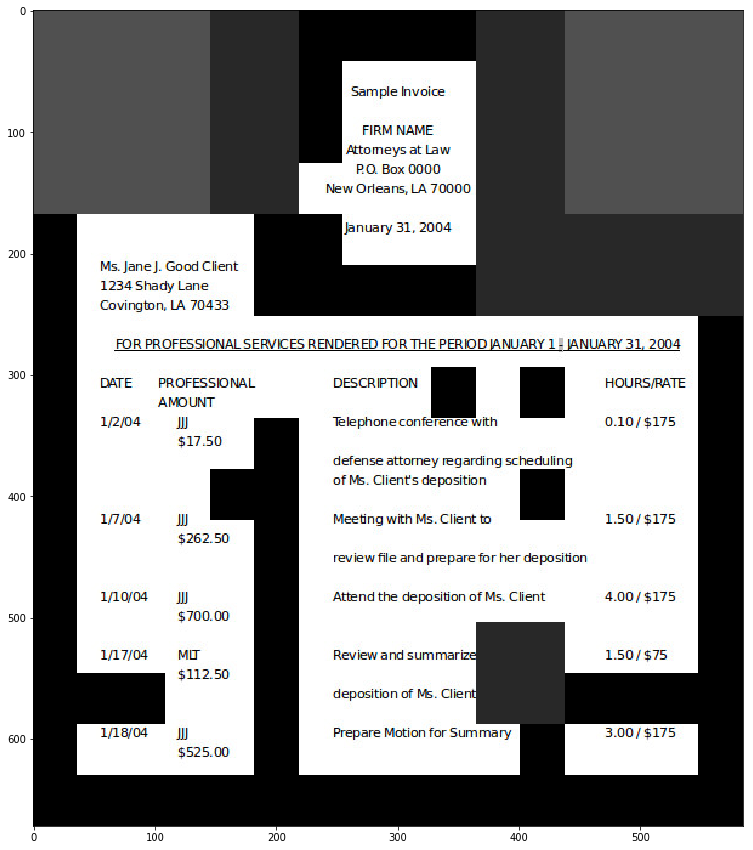

In [22]:
import random
import numpy as np

def is_clean_block(block):
    if np.var(block) == 0 and block[0][0] == True:
        return True
    return False

copy_img = np.copy(img)
copy_block = np.copy(img)
copy_block[:,:] = 255

def recurse_func(r1, r2, c1, c2, depth, multiplier):
    if depth == 0 or r1 == r2 or c1 == c2:
        return
    
    depth = depth - 1 #go deeper
    if is_clean_block(binary[r1:r2, c1:c2]):
        #print("record it:", r1, r2, c1, c2)
        copy_img[r1:r2, c1:c2] = depth*multiplier
        copy_block[r1:r2, c1:c2] = depth*multiplier
        return
    recurse_func(r1, int((r1+r2)/2), c1, int((c1+c2)/2), depth, multiplier)
    recurse_func(int((r1+r2)/2), r2, c1, int((c1+c2)/2), depth, multiplier)
    recurse_func(r1, int((r1+r2)/2), int((c1+c2)/2), c2, depth, multiplier)
    recurse_func(int((r1+r2)/2), r2, int((c1+c2)/2), c2, depth, multiplier)
        
        
r , c = binary.shape
depth = 5
multiplier = 200/depth
recurse_func(0, r, 0, c, depth, multiplier)

plt.figure(figsize=(15,15))
plt.imshow(copy_img, cmap="gray")

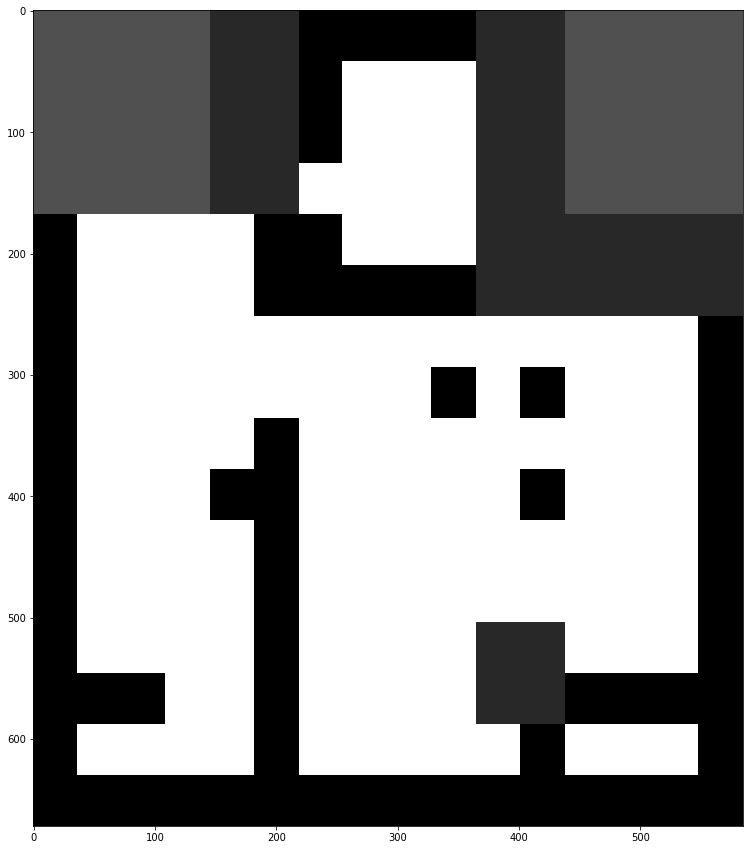

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(copy_block, cmap="gray")
# copy_img = np.copy(img)
# copy_img[336:672,292:585] = random.randint(10,255)
# plt.figure(figsize=(5,5))
# plt.imshow(copy_img, cmap="gray")

In [ ]:
240/7